In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing all libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [12]:
labels = ["Level 1", "Level 2", "Level 3"] #, "Level 4", "Level 5"]

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Set labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set title and labels
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Show the plot
    plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluation(y_train_pred, y_test_pred, y_train, y_test):
  print("train_evaluation:\n")
  print(classification_report(y_train_pred, y_train))
  print(confusion_matrix(y_train_pred, y_train))
  print("\ntest_evaluation:\n")
  print(classification_report(y_test_pred, y_test))
  print(confusion_matrix(y_test_pred, y_test))
  plot_confusion_matrix(confusion_matrix(y_test_pred, y_test), labels)

In [16]:
def model(data, test_size = 0.2, use_smote_technique=1):
    
    data1 = data

    # Seperate the target variable 
    X = data1.drop(columns = ['level'])
    y = data1['level']

    data1['level'].value_counts()

    # Split the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 2, stratify = y)

    # Smote the data
    if use_smote_technique == 1:
        # Count the class distribution before applying SMOTE
        print("Class distribution before SMOTE:", Counter(y_train))

        # Apply SMOTE to the dataset
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Count the class distribution after applying SMOTE
        print("Class distribution after SMOTE:", Counter(y_train))

    # Random Forest Classifier - Machine Learning Model
    rfc=RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=15)
    param_grid = {
        'max_depth': [3, 5, 7],                      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 3],               # Minimum number of samples required at a leaf node
        'max_features': ['auto', 'sqrt', 'log2'],    # Number of features to consider at each split
        'criterion': ['gini', 'entropy', 'log_loss'],
        'oob_score': [True],
        # 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
        # 'class_weight': ['balanced', 'balanced_subsample']    
    }


    # Perform grid search to find the best combination of parameters
    grid_search = GridSearchCV(rfc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtain the best values and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Evaluation of model
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    evaluation(y_train_pred, y_test_pred, y_train, y_test)

    # obtain Best Features
    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature Importance Rankings:")
    for i, feature in enumerate(X.columns[indices]):
        print(f"{i + 1}. {feature}: {importances[indices[i]] * 100}")

In [6]:
math_problems = pd.read_csv("../NLP/all_data_cat.csv")
math_problems.head()

,problem,level,type,modified_problem,no_of_equations,no_of_variables,has_exp,has_mod,has_logarithm,has_fraction,...,PUNCT,SCONJ,SYM,VERB,X,sentence_count_cat,word_count_cat,words_per_sentence_cat,average_word_length_cat,large_words_cat
0,Kevin Kangaroo begins hopping on a number line...,Level 5,Algebra,Kevin Kangaroo begins hopping on a number line...,2,1,False,False,False,True,...,6,3,0,11,0,2,4,2,1,4
1,The ratio of the areas of two squares is $\fra...,Level 4,Algebra,The ratio of the areas of two squares is . Aft...,3,5,True,False,False,True,...,6,1,0,3,0,1,4,3,1,4
2,"If $\sqrt{2\sqrt{t-2}} = \sqrt[4]{7 - t}$, the...",Level 4,Algebra,"If , then find .",1,2,True,False,False,False,...,2,1,0,1,0,0,0,0,0,0
3,Let $t(x) = \sqrt{3x+1}$ and $f(x)=5-t(x)$. Wh...,Level 4,Algebra,Let and . What is ?,3,3,True,False,False,False,...,2,0,0,1,0,0,0,0,0,0
4,James has a total of 66 dollars in his piggy b...,Level 2,Algebra,James has a total of 66 dollars in his piggy b...,0,0,False,False,False,False,...,4,2,0,4,0,1,4,3,0,0


In [7]:
size_mapping = {"Prealgebra": 1, "Intermediate Algebra": 2, "Algebra": 3}
math_problems['type'] = math_problems['type'].replace(size_mapping)

In [8]:
# Level1 + Level2 -> Level1, Level3->Level2, Level4+Level5 -> Level3
def club_class(class_var):
    if class_var == 'Level 1' or class_var == 'Level 2':
        return 'Level 1'
    elif class_var == 'Level 3':
        return 'Level 2'
    else:
        return 'Level 3'

math_problems['level'] = math_problems['level'].apply(club_class)

In [9]:
NER_FEATURES = ['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

POS_FEATURES = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

LINGUISTIC_CAT_FEATURES = ['sentence_count_cat', 'word_count_cat', 'words_per_sentence_cat', 'average_word_length_cat', 'large_words_cat']

LINGUISTIC_NUM_FEATURES = ['sentence_count', 'word_count', 'words_per_sentence', 'average_word_length', 'large_words']

MATH_CAT_FEATURES = ['has_exp', 'has_mod', 'has_logarithm', 'has_fraction', 'has_eq', 'has_neq']

MATH_NUM_FEATURES = ['exp_count', 'mod_count', 'log_count', 'fracs_count', 'eqlts_count', 'neqlts_count', 'max_degree_of_equations']

MANDATORY_FEATURES = ['no_of_equations', 'no_of_variables', 'type']

TARGET_FEATURE = ['level']

Experiment 1: Consider the following features

1. Categorised linguistic features
2. Categorical math features (eg: has_exp, has_log)
3. no_of_equations
4. no_of_variables

Run Random forest for the default 5 level classification and report the results

In [65]:
data1 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5835304985120021
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.57      0.61      0.58       892
     Level 2       0.06      0.74      0.11        62
     Level 3       0.90      0.62      0.73      2434

    accuracy                           0.62      3388
   macro avg       0.51      0.66      0.48      3388
weighted avg       0.80      0.62      0.68      3388

[[ 540  187  165]
 [  11   46    5]
 [ 404  521 1509]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.48      0.50      0.49       232
     Level 2       0.01      0.29      0.02         7
     Level 3       0.86      0.59      0.70       609

    accuracy                           0.56       848
   macro avg       0.45      0.46      0.40       848
weighted avg       0.7

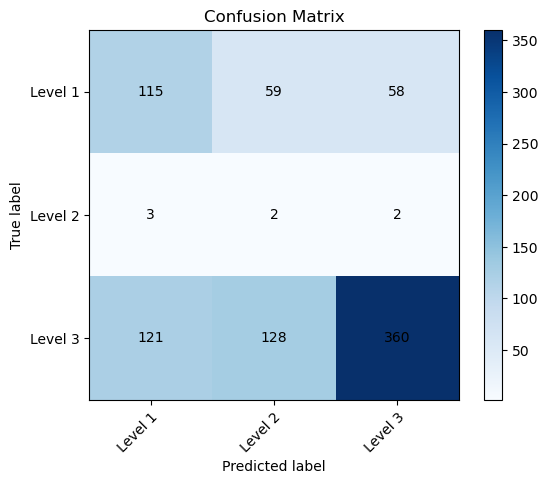

Feature Importance Rankings:
1. no_of_variables: 18.269089840029075
2. large_words_cat: 17.435642966430972
3. no_of_equations: 12.96712926427544
4. words_per_sentence_cat: 10.58202980834758
5. word_count_cat: 9.305064182041477
6. average_word_length_cat: 6.818015315759693
7. has_exp: 6.607399253969712
8. type: 5.416069872132188
9. has_fraction: 3.0660755508692814
10. sentence_count_cat: 3.002100023359543
11. has_neq: 2.7424938085858623
12. has_mod: 1.3532214170254457
13. has_logarithm: 1.2382804704054526
14. has_eq: 1.19738822676828


In [66]:
model(data1)

Experiment 2: Consider the following features

1. Categorised linguistic features
2. All numerical math features

Run Random forest with default 5 class classification and report the results

In [67]:
data2 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5838241765902843
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.58      0.60      0.59       928
     Level 2       0.06      0.83      0.11        52
     Level 3       0.89      0.62      0.73      2408

    accuracy                           0.62      3388
   macro avg       0.51      0.68      0.48      3388
weighted avg       0.80      0.62      0.68      3388

[[ 555  195  178]
 [   8   43    1]
 [ 392  516 1500]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.51      0.51      0.51       238
     Level 2       0.02      0.57      0.04         7
     Level 3       0.86      0.60      0.71       603

    accuracy                           0.57       848
   macro avg       0.46      0.56      0.42       848
weighted avg       0.7

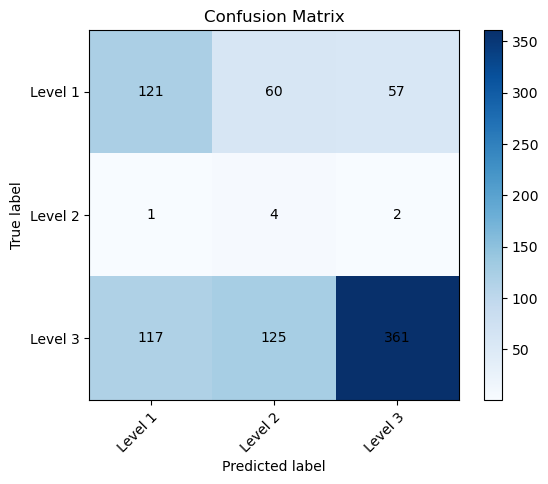

Feature Importance Rankings:
1. large_words_cat: 15.495388496114435
2. no_of_variables: 15.211451277416192
3. no_of_equations: 12.499689256184254
4. word_count_cat: 10.085445343866846
5. max_degree_of_equations: 9.405253223221417
6. words_per_sentence_cat: 7.694118203183821
7. exp_count: 6.94913118386231
8. average_word_length_cat: 5.42855514321129
9. type: 5.372395364181439
10. fracs_count: 4.089146279522468
11. neqlts_count: 2.598287515922295
12. sentence_count_cat: 2.2757866780386204
13. eqlts_count: 1.343034753189956
14. log_count: 1.0434481161520384
15. mod_count: 0.5088691659326329


In [68]:
model(data2)

Experiment 3: Consider the following features

1. Categorised linguistic features
2. Categorical math features
3. POS features
4. no_of_equations
5. no_of_variables

Run Random Forest on the default 5 class classification and report the results



In [10]:
data3 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + POS_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 3': 1679, 'Level 1': 955, 'Level 2': 754})
Class distribution after SMOTE: Counter({'Level 2': 1679, 'Level 1': 1679, 'Level 3': 1679})
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 32, 'oob_score': True}
Best Score:  0.6114866568938069
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.72      0.67      0.69      1818
     Level 2       0.58      0.66      0.62      1475
     Level 3       0.72      0.70      0.71      1744

    accuracy                           0.68      5037
   macro avg       0.68      0.67      0.67      5037
weighted avg       0.68      0.68      0.68      5037

[[1211  393  214]
 [ 247  976  252]
 [ 221  310 1213]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.50      0.46      0.48       258
     Level 2       0.19      0.19 

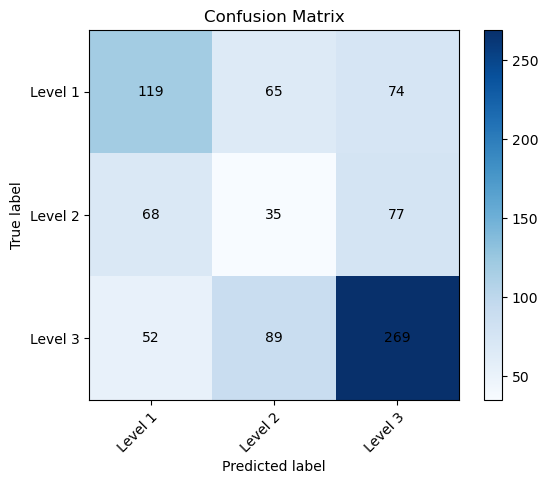

Feature Importance Rankings:
1. no_of_variables: 12.032073980919604
2. no_of_equations: 8.19066685304685
3. large_words_cat: 7.395404298300547
4. ADJ: 6.9540670652487675
5. VERB: 6.26713665442693
6. ADP: 5.496966711221316
7. PUNCT: 5.2016713951101705
8. has_exp: 5.143083905507143
9. DET: 5.037944124646128
10. NOUN: 4.842953897040633
11. word_count_cat: 3.476990548627786
12. average_word_length_cat: 3.1427625053004156
13. words_per_sentence_cat: 3.1237491968373727
14. NUM: 2.8041754581685754
15. AUX: 2.4836741255595576
16. type: 2.350631856441787
17. SCONJ: 2.160959672888516
18. CCONJ: 2.1571760005245686
19. PRON: 2.0599346210229017
20. has_fraction: 1.653218996513027
21. ADV: 1.6248977651291185
22. PROPN: 1.4980791020377593
23. has_neq: 1.1295371742980813
24. has_eq: 1.0053306248892797
25. X: 0.862524740831897
26. sentence_count_cat: 0.6205794214641754
27. SYM: 0.44639776259013664
28. PART: 0.4002870944360116
29. has_mod: 0.3269393604394396
30. has_logarithm: 0.11018508653150336
31. IN

In [14]:
model(data3)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.590617551840281
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.61      0.63      0.62       926
     Level 2       0.03      0.81      0.05        26
     Level 3       0.90      0.62      0.74      2436

    accuracy                           0.62      3388
   macro avg       0.51      0.69      0.47      3388
weighted avg       0.82      0.62      0.70      3388

[[ 580  186  160]
 [   2   21    3]
 [ 373  547 1516]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.53      0.53      0.53       239
     Level 2       0.00      0.00      0.00         1
     Level 3       0.88      0.61      0.72       608

    accuracy                           0.58       848
   macro avg       0.47      0.38      0.41       848
weighted avg       

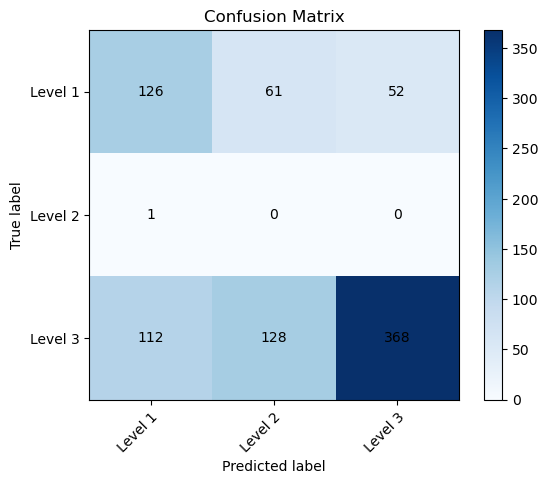

Feature Importance Rankings:
1. no_of_variables: 13.365609293826914
2. no_of_equations: 8.892202990913757
3. large_words_cat: 6.8210863760745255
4. ADJ: 6.730148437318071
5. NOUN: 6.471310721210591
6. VERB: 5.618606686729123
7. DET: 5.55554990905528
8. PUNCT: 5.045291855194473
9. ADP: 4.977297039227906
10. has_exp: 4.470071739420385
11. words_per_sentence_cat: 3.7285763152080404
12. PRON: 3.160625416344927
13. AUX: 2.725090457592456
14. word_count_cat: 2.3231294787617087
15. type: 2.2651196443872412
16. PROPN: 2.079753336025214
17. average_word_length_cat: 2.064775368127732
18. NUM: 2.0415718210754537
19. CCONJ: 1.9364916485894401
20. SCONJ: 1.879241617349973
21. ADV: 1.8748721808466053
22. has_fraction: 1.4333569030627724
23. has_neq: 1.375919570226844
24. SYM: 0.9708158457924159
25. sentence_count_cat: 0.5751253691542565
26. has_eq: 0.4145894150249933
27. X: 0.4064026315449981
28. PART: 0.38714508193799
29. has_mod: 0.28172572506493043
30. has_logarithm: 0.1284971249109853
31. INTJ: 

In [28]:
model(data3, use_smote_technique=0)

Experiment 4: Consider the following features

1. Categorised linguistic features
2. Numerical math features
3. POS features

Run Random Forest on the default 5 class classification and report the results



In [25]:
data4 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 3': 1679, 'Level 1': 955, 'Level 2': 754})
Class distribution after SMOTE: Counter({'Level 2': 1679, 'Level 1': 1679, 'Level 3': 1679})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5823099415204678
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.72      0.62      0.67      1949
     Level 2       0.45      0.64      0.53      1178
     Level 3       0.73      0.65      0.69      1910

    accuracy                           0.63      5037
   macro avg       0.63      0.64      0.63      5037
weighted avg       0.66      0.63      0.64      5037

[[1210  501  238]
 [ 216  754  208]
 [ 253  424 1233]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.56      0.50      0.53       269
     Level 2       0.19      0.22      0.20       

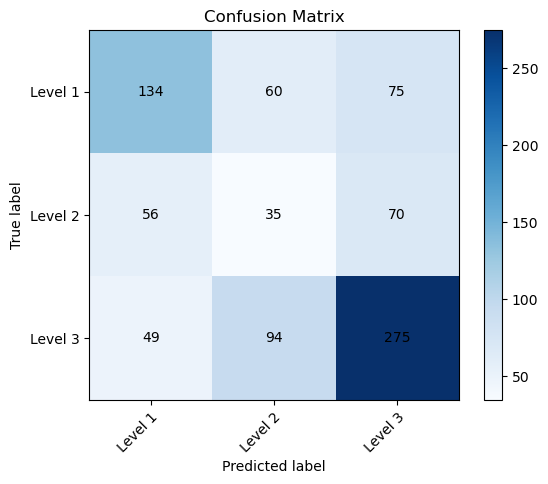

Feature Importance Rankings:
1. max_degree_of_equations: 13.486256132749263
2. VERB: 7.525414385520373
3. NOUN: 7.1861448034495385
4. exp_count: 6.687506915422511
5. large_words_cat: 6.094879252278873
6. PUNCT: 5.810270770126031
7. ADJ: 5.707660485899747
8. DET: 4.6377449368358175
9. word_count_cat: 4.554571717010577
10. average_word_length_cat: 4.126897495853448
11. CCONJ: 3.9444684503509935
12. ADP: 3.9129960850377787
13. AUX: 3.861921217174966
14. words_per_sentence_cat: 3.1977180492316246
15. PRON: 2.9587302415190915
16. NUM: 2.737399035104655
17. fracs_count: 2.653580610571259
18. SCONJ: 2.185424862310426
19. ADV: 1.6108384044341328
20. PROPN: 1.4496942666936152
21. eqlts_count: 1.2639542026946358
22. X: 1.1653380230560533
23. neqlts_count: 0.7987659120540533
24. PART: 0.6312042447413584
25. sentence_count_cat: 0.6180975881720495
26. SYM: 0.5701270489679475
27. mod_count: 0.4681867502113221
28. log_count: 0.15420811252787053
29. CONJ: 0.0
30. INTJ: 0.0


In [26]:
model(data4)

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5850110891796622
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.59      0.63      0.61       900
     Level 2       0.02      0.94      0.04        17
     Level 3       0.92      0.62      0.74      2471

    accuracy                           0.63      3388
   macro avg       0.51      0.73      0.46      3388
weighted avg       0.83      0.63      0.70      3388

[[ 565  199  136]
 [   0   16    1]
 [ 390  539 1542]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.49      0.52      0.50       227
     Level 2       0.01      0.67      0.02         3
     Level 3       0.87      0.59      0.70       618

    accuracy                           0.57       848
   macro avg       0.46      0.59      0.41       848
weighted avg       0.7

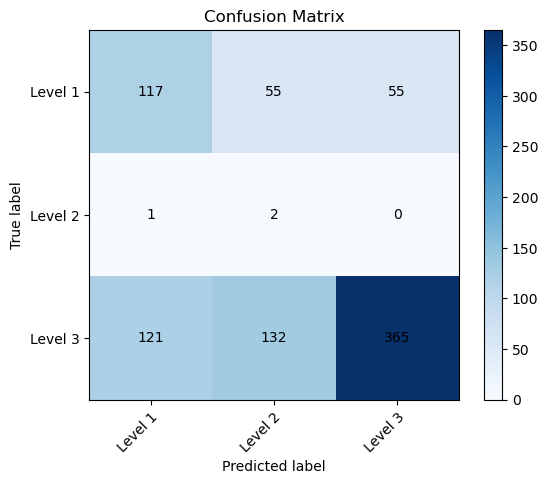

Feature Importance Rankings:
1. max_degree_of_equations: 9.363002159775412
2. VERB: 9.224932869219357
3. exp_count: 8.536227293759882
4. ADJ: 8.153300688869198
5. large_words_cat: 7.474272778593326
6. NOUN: 7.231049303190941
7. word_count_cat: 5.54648103907268
8. PUNCT: 5.210014952165668
9. ADP: 5.19807489236384
10. DET: 4.5139707259322375
11. AUX: 2.984696153167405
12. ADV: 2.7950170962753313
13. NUM: 2.780992524233577
14. PRON: 2.5712987095996565
15. fracs_count: 2.4926802636557244
16. PROPN: 2.0441610173449325
17. CCONJ: 1.9818414104493844
18. words_per_sentence_cat: 1.9724594581883081
19. SCONJ: 1.9314289669078486
20. average_word_length_cat: 1.9015726490193365
21. neqlts_count: 1.6683805609847557
22. eqlts_count: 1.0106572929836655
23. X: 0.92652534175488
24. PART: 0.747033188907578
25. SYM: 0.5863244148184663
26. mod_count: 0.4855824050594758
27. log_count: 0.4617144271528959
28. sentence_count_cat: 0.20630741655423643
29. CONJ: 0.0
30. INTJ: 0.0


In [27]:
model(data4, use_smote_technique=0)

All columns

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5903247452103023
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.57      0.61      0.59       887
     Level 2       0.03      0.87      0.05        23
     Level 3       0.91      0.61      0.73      2478

    accuracy                           0.62      3388
   macro avg       0.50      0.70      0.46      3388
weighted avg       0.81      0.62      0.69      3388

[[ 541  191  155]
 [   2   20    1]
 [ 412  543 1523]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.48      0.50      0.49       229
     Level 2       0.01      1.00      0.02         2
     Level 3       0.86      0.59      0.70       617

    accuracy                           0.56       848
   macro avg       0.45      0.69      0.40       848
weighted avg       0.7

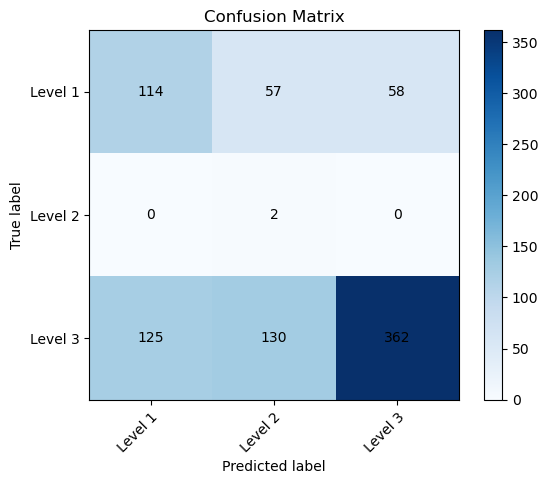

Feature Importance Rankings:
1. no_of_variables: 11.502651647368415
2. word_count: 6.7949640656074655
3. large_words: 5.320157862850138
4. ADJ: 4.956525573884167
5. exp_count: 4.4901693768643
6. no_of_equations: 4.171670750961146
7. NOUN: 4.001452254351587
8. ADP: 3.748229802979159
9. words_per_sentence: 3.7441084998389975
10. VERB: 3.5951318175662723
11. max_degree_of_equations: 3.141943498462299
12. DET: 2.9257251078140696
13. PUNCT: 2.83416842409358
14. word_count_cat: 2.8040215244428275
15. average_word_length_cat: 2.6758435453067766
16. words_per_sentence_cat: 2.5821462251029317
17. large_words_cat: 2.5299369387552932
18. has_exp: 2.0371067042838895
19. PRON: 1.9422056317528806
20. CCONJ: 1.8434766520448602
21. NUM: 1.537075436097277
22. neqlts_count: 1.3766672414892906
23. SCONJ: 1.2992082383756838
24. type: 1.2809319242729311
25. fracs_count: 1.2597871145436461
26. average_word_length: 1.234889994028181
27. AUX: 1.1885135274175844
28. PROPN: 1.151739885338428
29. sentence_count:

In [73]:
model(math_problems.drop(columns=['problem', 'modified_problem']))

In [17]:
data5 = math_problems[LINGUISTIC_CAT_FEATURES + LINGUISTIC_NUM_FEATURES + MATH_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 3': 1679, 'Level 1': 955, 'Level 2': 754})
Class distribution after SMOTE: Counter({'Level 2': 1679, 'Level 1': 1679, 'Level 3': 1679})
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5975971769045254
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.72      0.66      0.69      1827
     Level 2       0.56      0.63      0.59      1490
     Level 3       0.70      0.68      0.69      1720

    accuracy                           0.66      5037
   macro avg       0.66      0.66      0.66      5037
weighted avg       0.66      0.66      0.66      5037

[[1202  404  221]
 [ 269  936  285]
 [ 208  339 1173]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.51      0.47      0.49       264
     Level 2       0.19      0.19      0.19       193


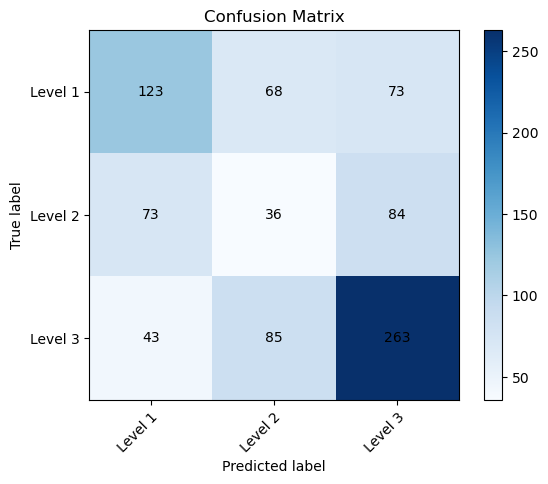

Feature Importance Rankings:
1. no_of_variables: 13.559680495875131
2. no_of_equations: 7.647036587330806
3. large_words_cat: 7.034848592827165
4. ADJ: 5.155516518790053
5. max_degree_of_equations: 4.539292367903216
6. VERB: 4.538531423185564
7. word_count: 4.4072352193862745
8. DET: 4.176542168924969
9. ADP: 4.1354685569450105
10. large_words: 3.935837384703219
11. NOUN: 3.9081666500954846
12. PUNCT: 3.1953250133098874
13. has_exp: 3.1471726641246556
14. words_per_sentence: 2.849095197737811
15. AUX: 2.4343380577938256
16. exp_count: 2.308568794533389
17. average_word_length: 2.1170906451686755
18. ADV: 1.999744744658884
19. average_word_length_cat: 1.806942652258003
20. CCONJ: 1.5997926268724225
21. PRON: 1.5951456158799746
22. word_count_cat: 1.3411003090517075
23. words_per_sentence_cat: 1.3196585506256688
24. NUM: 1.2441496673950585
25. PROPN: 1.1740729573002366
26. sentence_count: 1.137735091230274
27. fracs_count: 0.9696599503444071
28. SCONJ: 0.923224408713162
29. type: 0.87563

In [18]:
model(data5)

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5879570201696709
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.61      0.63      0.62       928
     Level 2       0.03      0.90      0.07        29
     Level 3       0.91      0.63      0.74      2431

    accuracy                           0.63      3388
   macro avg       0.52      0.72      0.48      3388
weighted avg       0.82      0.63      0.70      3388

[[ 584  193  151]
 [   2   26    1]
 [ 369  535 1527]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.53      0.54      0.54       235
     Level 2       0.01      0.50      0.02         4
     Level 3       0.87      0.60      0.71       609

    accuracy                           0.58       848
   macro avg       0.47      0.55      0.42       848
weighted avg       0.

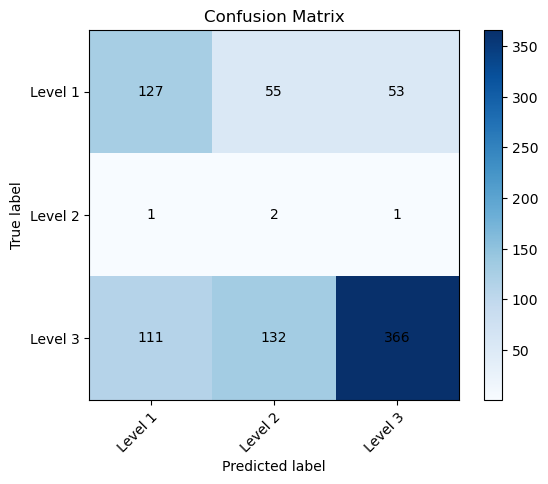

Feature Importance Rankings:
1. no_of_variables: 9.75451475951222
2. ADJ: 8.749633201097398
3. NOUN: 6.068148892562726
4. large_words_cat: 6.021554762073302
5. no_of_equations: 5.996186592946988
6. DET: 5.074110915949546
7. max_degree_of_equations: 4.711357833917038
8. ADP: 4.421650927634614
9. VERB: 4.280812354701195
10. exp_count: 4.112311501216929
11. PUNCT: 3.52867474638069
12. word_count_cat: 3.2806480671791016
13. AUX: 3.1360235487753183
14. NUM: 3.123015639436477
15. words_per_sentence_cat: 2.6782880926838115
16. average_word_length_cat: 2.483552306546403
17. type: 2.4813812769150574
18. SCONJ: 2.2029308163506625
19. PRON: 2.1626171030140693
20. fracs_count: 1.9591434426325
21. PROPN: 1.9488767426440214
22. has_exp: 1.8895591190002674
23. ADV: 1.8394654208856067
24. CCONJ: 1.7740276311415246
25. X: 0.9299652410207643
26. neqlts_count: 0.8604419012344181
27. PART: 0.7562173609096263
28. sentence_count_cat: 0.6978344146284033
29. SYM: 0.643610657170792
30. eqlts_count: 0.599610514

In [31]:
model(data5, use_smote_technique=0)

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5888476403358561
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.61      0.64      0.63       917
     Level 2       0.04      0.76      0.07        38
     Level 3       0.91      0.63      0.75      2433

    accuracy                           0.63      3388
   macro avg       0.52      0.68      0.48      3388
weighted avg       0.82      0.63      0.71      3388

[[ 585  189  143]
 [   6   29    3]
 [ 364  536 1533]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.51      0.53      0.52       233
     Level 2       0.02      0.30      0.03        10
     Level 3       0.86      0.60      0.71       605

    accuracy                           0.58       848
   macro avg       0.46      0.48      0.42       848
weighted avg       0.

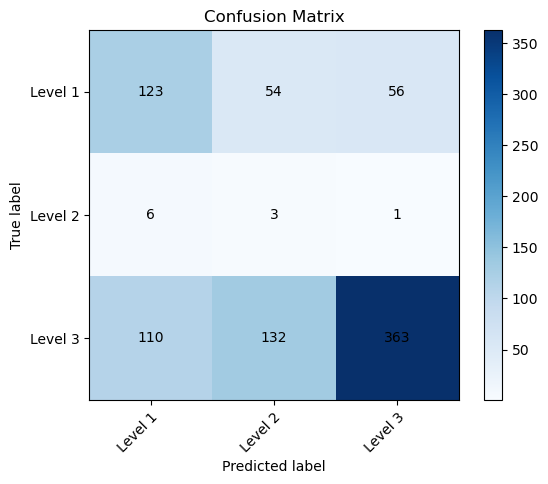

Feature Importance Rankings:
1. no_of_variables: 10.7345293718824
2. no_of_equations: 7.315399878207803
3. large_words_cat: 6.509281968834685
4. large_words: 6.1710050742687335
5. word_count: 5.370826606312425
6. max_degree_of_equations: 5.053290842343522
7. words_per_sentence: 4.975279507202364
8. ADJ: 4.914786522274177
9. ADP: 4.433891784887624
10. DET: 3.788908670838812
11. VERB: 3.6460613671039264
12. NOUN: 2.998885821568541
13. exp_count: 2.835002562758542
14. PUNCT: 2.5463442501359417
15. average_word_length: 2.3356120910189917
16. has_exp: 2.3281507182751264
17. NUM: 2.043669772495248
18. type: 2.0429045150136655
19. word_count_cat: 1.8878064405386075
20. words_per_sentence_cat: 1.8192284153573708
21. PRON: 1.8061739147740754
22. AUX: 1.781631553821728
23. CCONJ: 1.5924981300826444
24. PROPN: 1.3653527615912506
25. fracs_count: 1.3111894313314973
26. ADV: 1.1901725842189987
27. average_word_length_cat: 0.9156383116463715
28. SCONJ: 0.8973966751939191
29. has_fraction: 0.81671546

In [19]:
model(data5, use_smote_technique=0)

In [47]:
math_problems['level'].value_counts()

Level 5    1116
Level 4     983
Level 3     943
Level 2     832
Level 1     362
Name: level, dtype: int64

In [49]:
math_problems['level'].value_counts()

Level 3    2099
Level 1    1194
Level 2     943
Name: level, dtype: int64

In [76]:
math_problems.shape

(4236, 66)